In [1]:
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

e:\Python\Python39\venv\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MNIST

##### Data preprocessing

In [4]:
# get data

data_path = '../data/'

transform = transforms.Compose([
    transforms.ToTensor()   # ToTensor() already normalizes pixel value from [0, 255] to [0, 1]
])

mnist_dataset = torchvision.datasets.MNIST(root=data_path, train=True, transform=transform, download=True)

# train val set
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, transform=transform, download=False)

In [5]:
# create dataloader
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)  # no need to shuffle the valid and test set

##### Model

In [7]:
model = nn.Sequential()

# conv layer with 1 channel (greyscale), 32 5x5 kernels (outputs 32 feature maps), zero padding of 2 and stride of 2 to preserve output dimension
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  # 2x2 kernel pooling would subsample the image by halving its dimension

# conv layer with 32 channel (input of 32 feature maps from last conv layer), 64 5x5 kernels (outputs 64 feature maps), zero padding of 2 and stride of 2 to preserve output dimension
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# flatten before connecting to FC layer (flatten to (batch_size, feature maps x H x W))
model.add_module('flatten', nn.Flatten())

# FC layer with input dimension num_featuremaps x H x W (64 x 7 x 7), 1024 units
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())

# output layer, 10 classes
model.add_module('fc2', nn.Linear(1024, 10))
# no need to explictly add softmax activation layer, because PyTorch CE loss already includes it

##### Train

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, num_epochs, train_dl, valid_dl):
    # keep track of metrics for each epoch
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    accuracy_hist_val = [0] * num_epochs

    for epoch in range(num_epochs):
        # switch to training to use dropout layer
        model.train()
        for x_batch, y_batch in train_dl:
            # forward predict
            pred = model(x_batch)
            # calculate error
            loss = loss_fn(pred, y_batch)
            # backward calculate gradient
            loss.backward()
            # update parameters using gradient
            optimizer.step()
            # reset gradient to 0
            optimizer.zero_grad()

            # track error
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            # track accuracy
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # switch to eval to not use dropout layer
        model.eval()

        # validation
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                # track error
                loss_hist_val[epoch] += loss.item() * y_batch.size(0)

                # track accuracy
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_val[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_val[epoch] /= len(valid_dl.dataset)
        accuracy_hist_val[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_val[epoch]:.4f}')

    return loss_hist_train, loss_hist_val, accuracy_hist_train, accuracy_hist_val

In [12]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9871 val_accuracy: 0.9842
Epoch 2 accuracy: 0.9909 val_accuracy: 0.9879
Epoch 3 accuracy: 0.9944 val_accuracy: 0.9824
Epoch 4 accuracy: 0.9951 val_accuracy: 0.9874
Epoch 5 accuracy: 0.9966 val_accuracy: 0.9881
Epoch 6 accuracy: 0.9970 val_accuracy: 0.9866
Epoch 7 accuracy: 0.9975 val_accuracy: 0.9891
Epoch 8 accuracy: 0.9974 val_accuracy: 0.9913
Epoch 9 accuracy: 0.9975 val_accuracy: 0.9889
Epoch 10 accuracy: 0.9983 val_accuracy: 0.9880
Epoch 11 accuracy: 0.9986 val_accuracy: 0.9893
Epoch 12 accuracy: 0.9977 val_accuracy: 0.9895
Epoch 13 accuracy: 0.9987 val_accuracy: 0.9876
Epoch 14 accuracy: 0.9991 val_accuracy: 0.9884
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9901
Epoch 16 accuracy: 0.9995 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9989 val_accuracy: 0.9883
Epoch 18 accuracy: 0.9978 val_accuracy: 0.9889
Epoch 19 accuracy: 0.9991 val_accuracy: 0.9929
Epoch 20 accuracy: 0.9993 val_accuracy: 0.9891


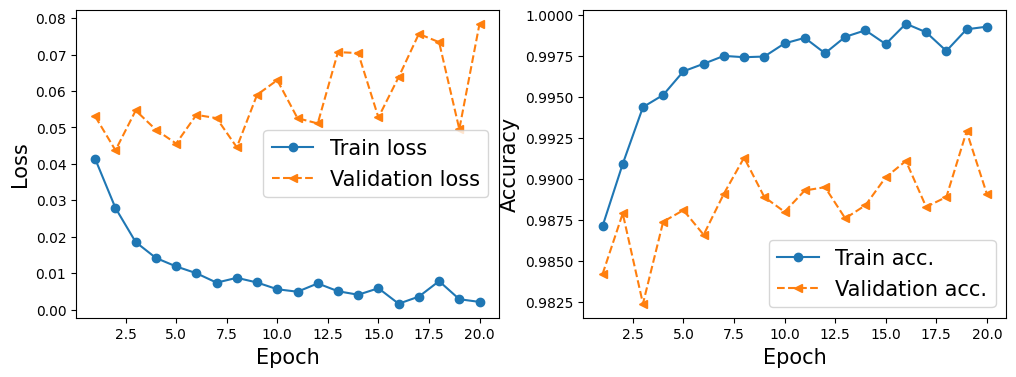

In [15]:
# plot
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [16]:
# eval on the test set
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9908


# Smile Classification

##### Data preprocessing

In [20]:
# get data

data_path = '../data/'

celeb_train_dataset = torchvision.datasets.CelebA(data_path, split='train', target_type='attr', download=False)
celeb_val_dataset = torchvision.datasets.CelebA(data_path, split='valid', target_type='attr', download=False)
celeb_test_dataset = torchvision.datasets.CelebA(data_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeb_train_dataset))
print('Val set:', len(celeb_val_dataset))
print('Test set:', len(celeb_test_dataset))

Train set: 162770
Val set: 19867
Test set: 19962


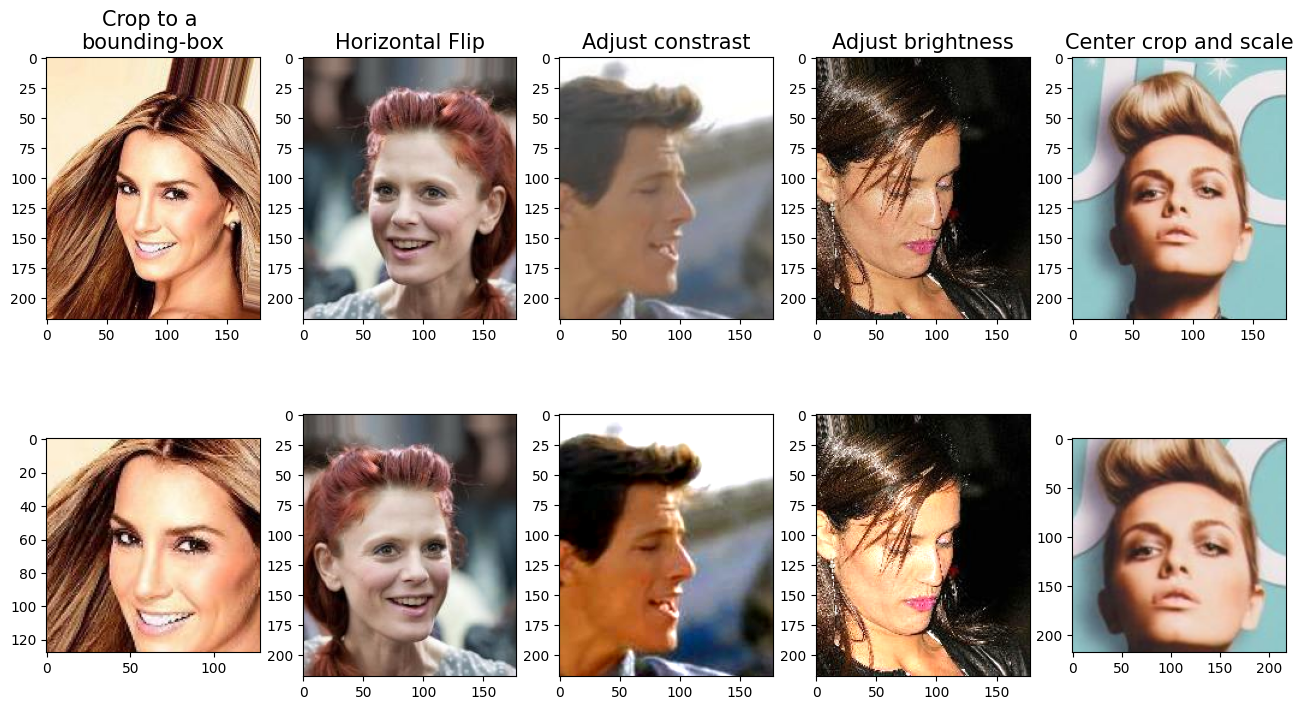

In [21]:
# data augmentation
fig = plt.figure(figsize=(16, 8.5))

# crop
ax = fig.add_subplot(2, 5, 1)
img, attr = celeb_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)  # crop to 128x128 from (50, 20)
ax.imshow(img_cropped)

# horizontal flip
ax = fig.add_subplot(2, 5, 2)
img, attr = celeb_train_dataset[1]
ax.set_title('Horizontal Flip', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

# adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeb_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_contrast)

# adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeb_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_brightness)

# cropping from image center, then scale to original
ax = fig.add_subplot(2, 5, 5)
img, attr = celeb_train_dataset[4]
ax.set_title('Center crop and scale', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*218])  # center crop
img_resized = transforms.functional.resize(img_center_crop, size=(218, 218))  # scale to original
ax.imshow(img_resized)

plt.show()


In [22]:
# data transform pipeline for train set (use random crop)
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

# for val and test set just crop (for same dimension for the model)
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

# get the label
get_smile = lambda attr: attr[31]

In [23]:
# load dataset with the transforms
celeb_train_dataset = torchvision.datasets.CelebA(data_path, split='train', target_type='attr', download=False, transform=transform_train, target_transform=get_smile)
celeb_val_dataset = torchvision.datasets.CelebA(data_path, split='valid', target_type='attr', download=False, transform=transform, target_transform=get_smile)
celeb_test_dataset = torchvision.datasets.CelebA(data_path, split='test', target_type='attr', download=False, transform=transform, target_transform=get_smile)

# only use subset of data
celeb_train_dataset = Subset(celeb_train_dataset, torch.arange(16000))
celeb_val_dataset = Subset(celeb_val_dataset, torch.arange(1000))

print('Train set:', len(celeb_train_dataset))
print('Validation set:', len(celeb_val_dataset))

Train set: 16000
Validation set: 1000


In [24]:
# create dataloader
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeb_train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(celeb_val_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeb_test_dataset, batch_size, shuffle=False)

##### Model

In [25]:
model = nn.Sequential()

# conv layer with 3 channel (RGB), 32 3x3 kernels (outputs 32 feature maps), zero padding of 1 and stride of 1 to preserve output dimension
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  # 2x2 kernel pooling would subsample the image by halving its dimension
model.add_module('drop1', nn.Dropout(p=0.5))

# conv layer with 32 channel (input of 32 feature maps from last conv layer), 64 3x3 kernels (outputs 64 feature maps), zero padding of 1 and stride of 1 to preserve output dimension
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('drop2', nn.Dropout(p=0.5))

# conv layer with 64 channel, 128 3x3 kernels (outputs 128 feature maps), zero padding of 1 and stride of 1 to preserve output dimension
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
# dropout usually added for early layers, so no dropout here

# conv layer with 128 channel, 256 3x3 kernels (outputs 256 feature maps), zero padding of 1 and stride of 1 to preserve output dimension
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

# use global average pooling before the output (instead of FC)
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

model.add_module('flatten', nn.Flatten())

# FC layer with input dimension num_featuremaps (since global average pooled)
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

##### Train

In [26]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
def train(model, num_epochs, train_dl, valid_dl):
    # keep track of metrics for each epoch
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    accuracy_hist_val = [0] * num_epochs

    for epoch in range(num_epochs):
        # switch to training to use dropout layer
        model.train()
        for x_batch, y_batch in train_dl:
            # forward predict
            pred = model(x_batch)[:, 0]
            # calculate error
            loss = loss_fn(pred, y_batch.float())
            # backward calculate gradient
            loss.backward()
            # update parameters using gradient
            optimizer.step()
            # reset gradient to 0
            optimizer.zero_grad()

            # track error
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            # track accuracy
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # switch to eval to not use dropout layer
        model.eval()

        # validation
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())

                # track error
                loss_hist_val[epoch] += loss.item() * y_batch.size(0)

                # track accuracy
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_val[epoch] += is_correct.sum()

        # compute average for this epoch
        loss_hist_val[epoch] /= len(valid_dl.dataset)
        accuracy_hist_val[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_val[epoch]:.4f}')

    return loss_hist_train, loss_hist_val, accuracy_hist_train, accuracy_hist_val

In [28]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, val_dl)

Epoch 1 accuracy: 0.5139 val_accuracy: 0.5130
Epoch 2 accuracy: 0.5334 val_accuracy: 0.5560
Epoch 3 accuracy: 0.5584 val_accuracy: 0.5640
Epoch 4 accuracy: 0.6008 val_accuracy: 0.5940
Epoch 5 accuracy: 0.6243 val_accuracy: 0.5970
Epoch 6 accuracy: 0.6351 val_accuracy: 0.6480
Epoch 7 accuracy: 0.6508 val_accuracy: 0.6650
Epoch 8 accuracy: 0.6652 val_accuracy: 0.6570
Epoch 9 accuracy: 0.6753 val_accuracy: 0.6530
Epoch 10 accuracy: 0.6920 val_accuracy: 0.7020
Epoch 11 accuracy: 0.7109 val_accuracy: 0.6910
Epoch 12 accuracy: 0.7253 val_accuracy: 0.7340
Epoch 13 accuracy: 0.7403 val_accuracy: 0.7630
Epoch 14 accuracy: 0.7549 val_accuracy: 0.7410
Epoch 15 accuracy: 0.7766 val_accuracy: 0.8030
Epoch 16 accuracy: 0.7936 val_accuracy: 0.8270
Epoch 17 accuracy: 0.8024 val_accuracy: 0.8430
Epoch 18 accuracy: 0.8128 val_accuracy: 0.8360
Epoch 19 accuracy: 0.8226 val_accuracy: 0.8490
Epoch 20 accuracy: 0.8300 val_accuracy: 0.8720
Epoch 21 accuracy: 0.8397 val_accuracy: 0.8720
Epoch 22 accuracy: 0.8

Text(0, 0.5, 'Accuracy')

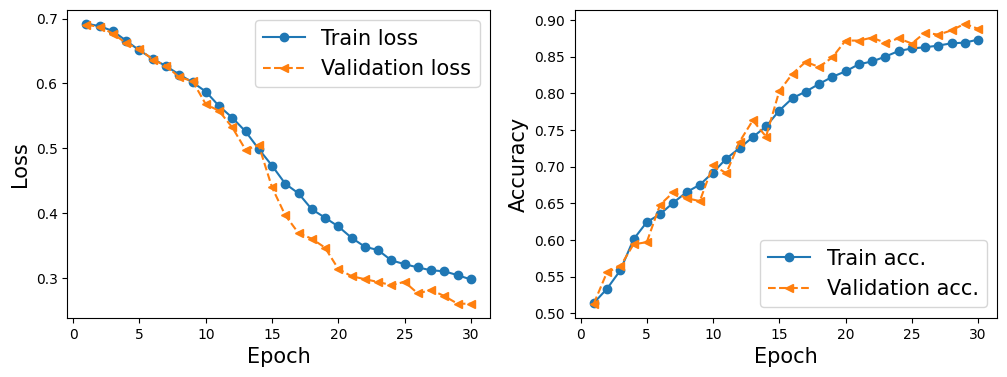

In [29]:
# plot
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


In [30]:
# eval on the test set
accuracy_test = 0
model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8948


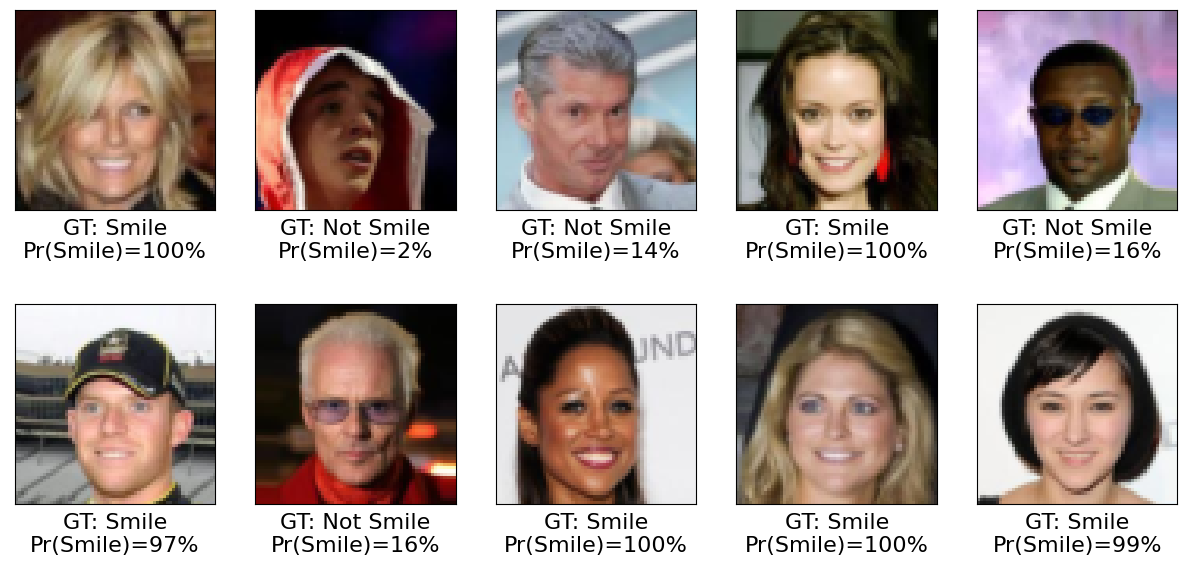

In [31]:
# plot some samples
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15, 
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
        
plt.show()